In [4]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9edd074f45d69b9bbd472c0a5c5098ab7064679b0d554419f2e989e9cefbd127
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=5749203720a8666791b312b92675944309cf38c5b5ab383c9f1ee674fc91d69b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [5]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 17.94 MiB/s, done.


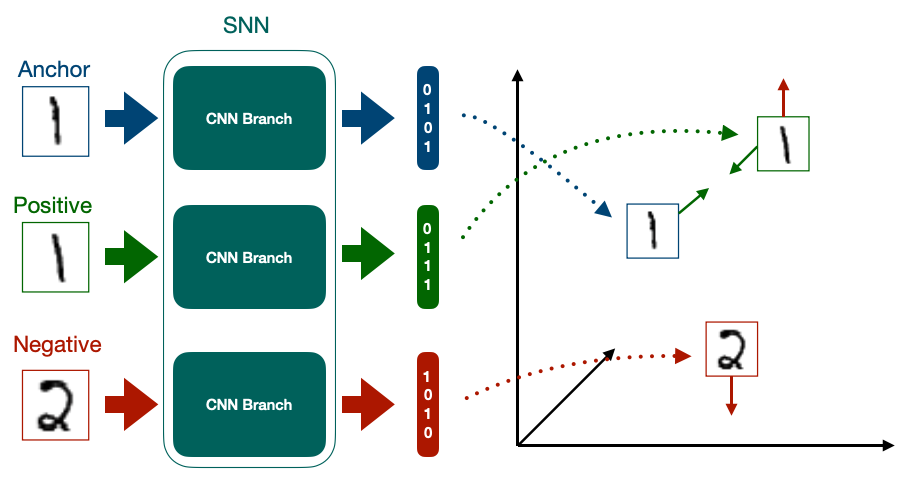

# Imports

In [6]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [8]:
Data_Dir = '/content/Person-Re-Id-Dataset/train/'
CSV_File = '/content/Person-Re-Id-Dataset/train.csv'

Batch_Size = 32
LR = 0.005
EPOCHS = 15

Device = 'cuda'

In [9]:
df = pd.read_csv(CSV_File)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [10]:
row = df.iloc[11]

A_img = io.imread(Data_Dir + row.Anchor)
P_img = io.imread(Data_Dir + row.Positive)
N_img = io.imread(Data_Dir + row.Negative)

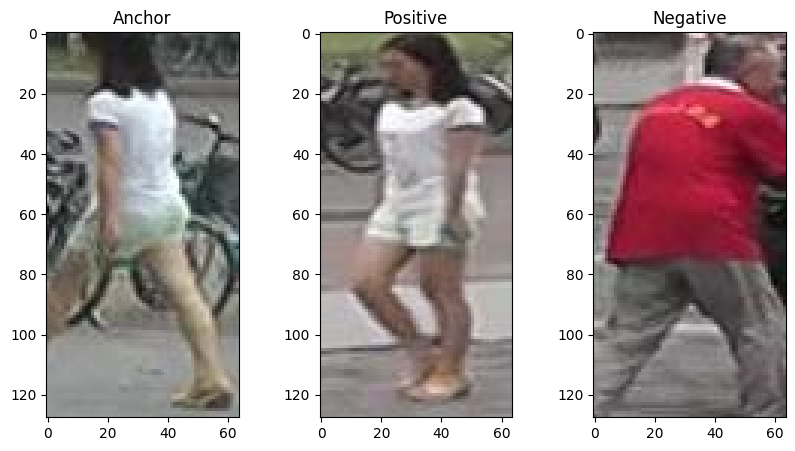

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)


In [12]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset

In [13]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    row = self.df.iloc[idx]


    A_img = io.imread(Data_Dir + row.Anchor)
    P_img = io.imread(Data_Dir + row.Positive)
    N_img = io.imread(Data_Dir + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [14]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


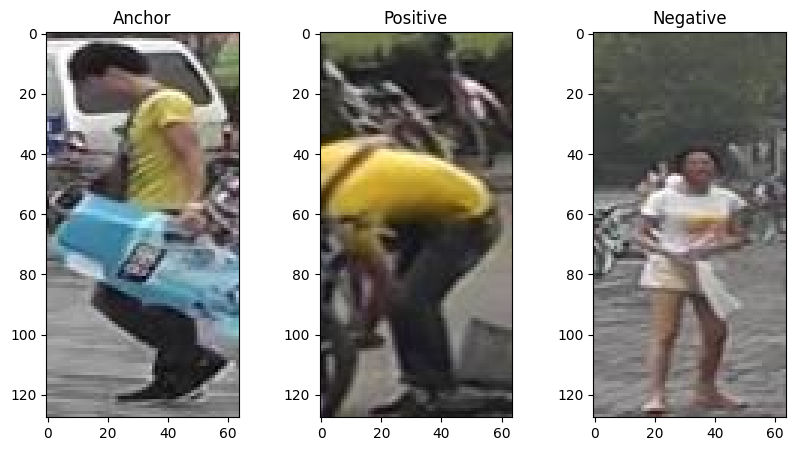

In [15]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [16]:
trainloader = DataLoader(trainset, batch_size = Batch_Size, shuffle = True)
validloader = DataLoader(validset, batch_size = Batch_Size)

In [17]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [18]:
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [19]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):

    embeddings = self.efficientnet(images)

    return embeddings

In [20]:
model = APN_Model()
model.to(Device);

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Create Train and Eval function

In [21]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
      A, P, N = A.to(Device), P.to(Device), N.to(Device)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

      return total_loss / len(dataloader)

In [22]:
def eval_fn(model, dataloader, criterion):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
        A, P, N = A.to(Device), P.to(Device), N.to(Device)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        total_loss += loss.item()

        return total_loss / len(dataloader)

In [23]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [24]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS")

    print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.01088820219039917 valid_loss : 0.0


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 2 train_loss : 0.010491597652435302 valid_loss : 0.016205253601074218


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 3 train_loss : 0.01557856321334839 valid_loss : 0.07950067520141602


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 4 train_loss : 0.0 valid_loss : 0.07544925689697266


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 5 train_loss : 0.0 valid_loss : 0.09166923522949219


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 6 train_loss : 0.0 valid_loss : 0.09595539093017579


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 7 train_loss : 0.0 valid_loss : 0.08485549926757813


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 8 train_loss : 0.0 valid_loss : 0.04869438171386719


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 9 train_loss : 0.0 valid_loss : 0.10439369201660156


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 10 train_loss : 0.0 valid_loss : 0.12124671936035156


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 11 train_loss : 0.0 valid_loss : 0.0


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 12 train_loss : 0.0 valid_loss : 0.0


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 13 train_loss : 0.0 valid_loss : 0.0


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 14 train_loss : 0.0 valid_loss : 0.0


  0%|          | 0/25 [00:00<?, ?it/s]

EPOCHS : 15 train_loss : 0.0 valid_loss : 0.0


# Get Anchor Embeddings

In [25]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(Data_Dir + i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A.to(Device)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [26]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:46<00:00, 85.65it/s]


In [28]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.116457,0.022985,0.307405,-0.152467,0.012665,-0.329047,0.236927,0.202258,-0.175206,...,0.156782,-0.353859,-0.206131,0.226159,0.080650,0.068049,-0.460929,-0.250355,-0.098388,-0.348198
1,1420_c3s3_061978_03.jpg,-0.229686,0.045044,0.107649,0.102583,0.069951,0.077176,-0.000467,0.003329,-0.269340,...,0.274172,-0.248646,-0.090204,0.125710,0.016627,0.237021,-0.132814,0.013412,0.032685,-0.661501
2,1420_c5s3_062565_05.jpg,-0.046148,0.071130,0.080275,-0.258718,0.078146,0.050588,0.185932,-0.185301,-0.286347,...,0.053483,0.049634,0.183468,-0.093931,0.032080,0.189156,-0.026150,-0.048294,-0.026991,-0.366261
3,1420_c6s3_085592_04.jpg,0.020881,0.315513,-0.033549,0.117625,-0.144469,0.246199,0.041919,-0.180785,-0.017725,...,0.098174,0.121567,-0.024102,0.290632,0.182358,-0.219819,-0.220904,0.060113,-0.151228,0.200511
4,0663_c5s3_085987_03.jpg,-0.085974,0.033113,0.101223,-0.241333,-0.073625,0.290645,-0.045752,-0.180685,-0.370831,...,0.149166,0.402471,0.015861,-0.078280,0.060627,0.064423,-0.071925,0.181017,0.249477,-0.329539


# Inference

In [29]:
def eculidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
    return dist

In [41]:
idx = 55
img_name = df_enc['Anchor'].iloc[idx]
img_path = Data_Dir + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(Device)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [42]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [43]:
from huggingface_hub import edit_discussion_comment
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = eculidean_dist(img_enc, anc_enc_arr[i : i+1, :])
    distance = np.append(distance, dist)

In [44]:
closest_idx = np.argsort(distance)

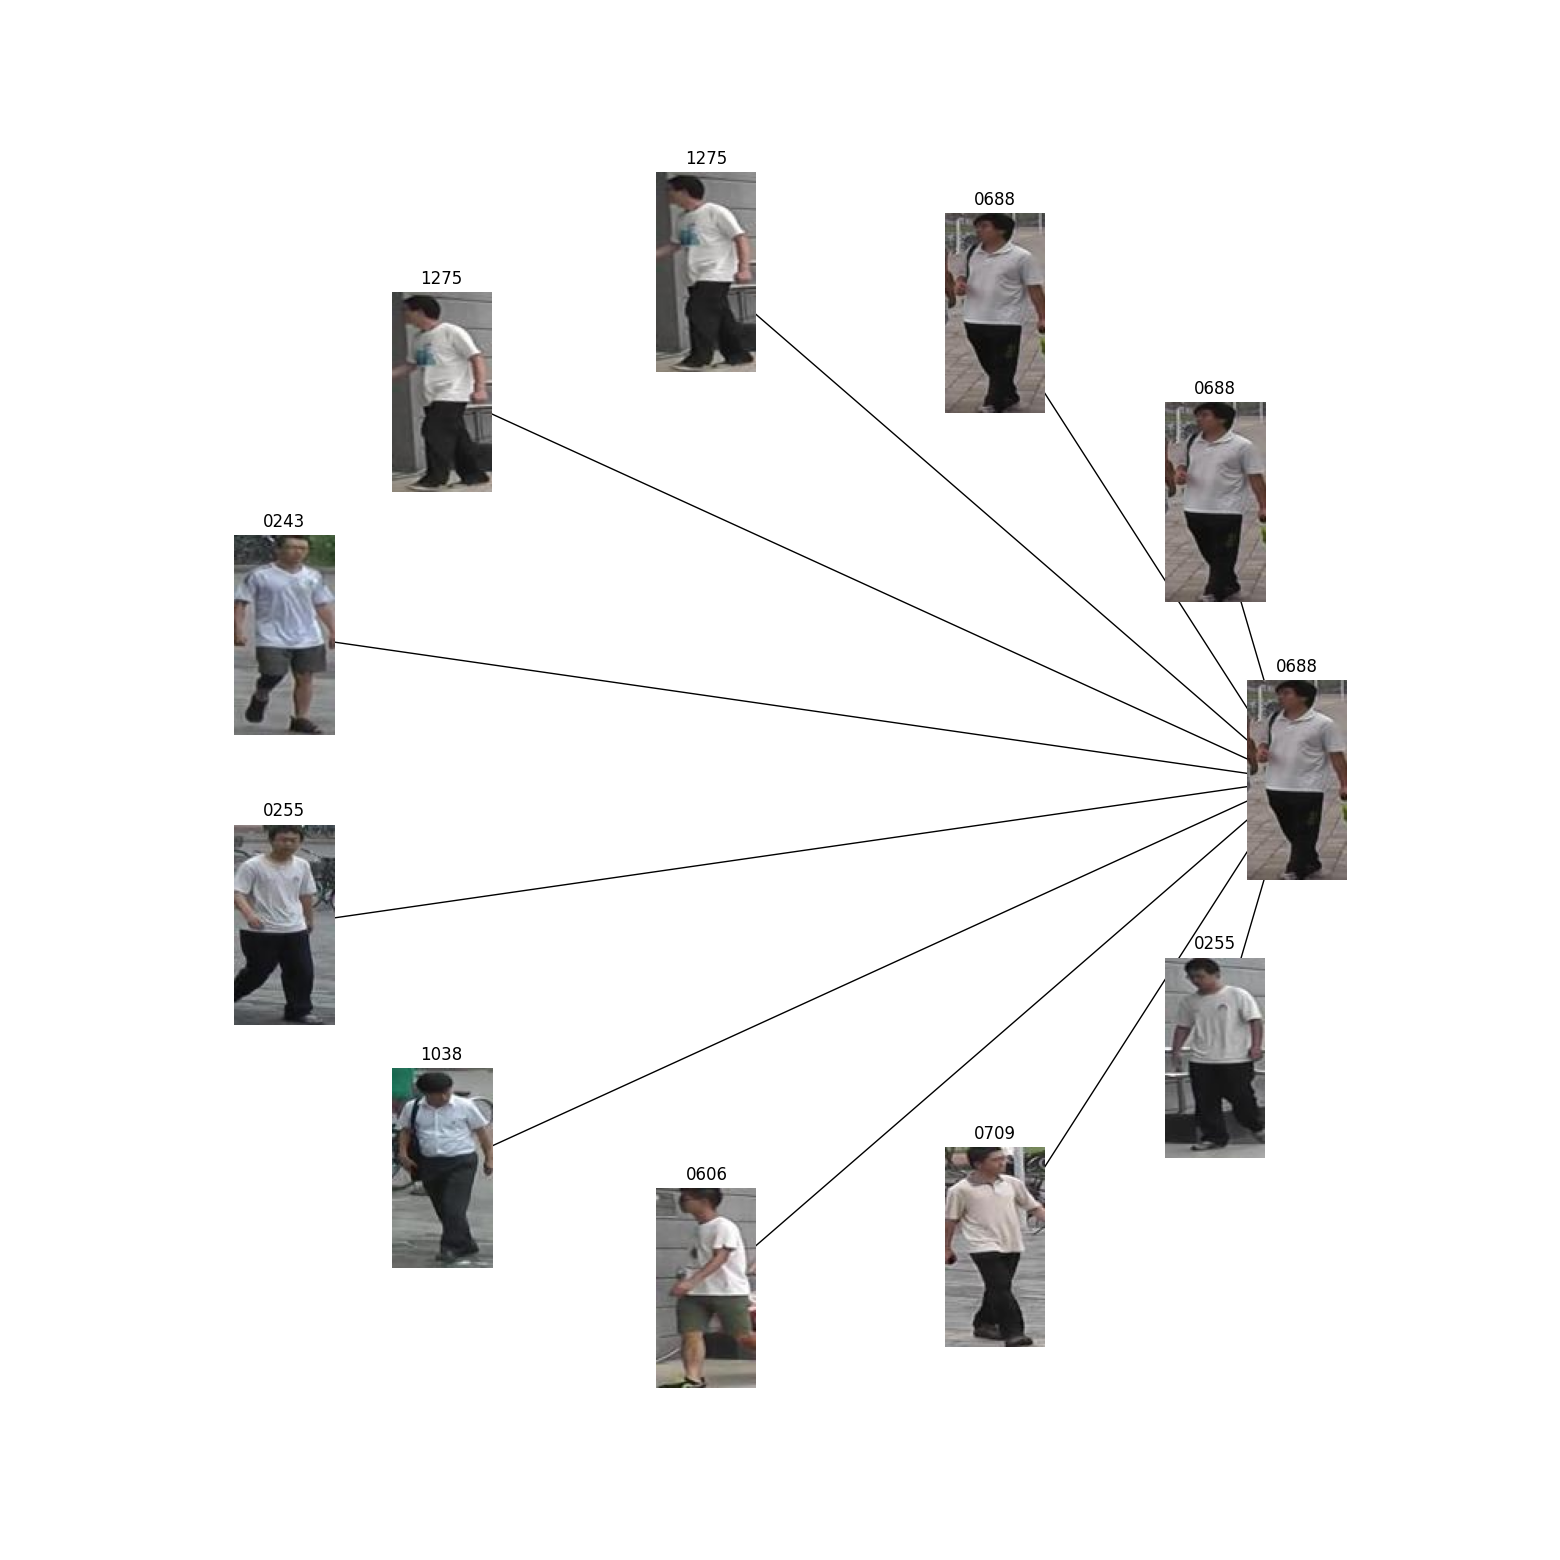

In [46]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, Data_Dir, img, img_path, closest_idx, distance, no_of_closest = 10);